In [1]:
import sys

import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from neuralpredictors.measures.np_functions import corr, fev
sys.path.append('/home/charon/project/sensorium/')
sys.path.append('/home/charon/project/')
from shallowmind.api.infer import prepare_inference
from shallowmind.api.eval import test

In [30]:
cfg = '/data2/charon/sensorium/sensorium_baseline/sensorium_baseline.py'
ckpt = '/data2/charon/sensorium/sensorium_baseline/ckpts/exp_name=sensorium_baseline-cfg=sensorium_baseline-val_correlation=0.299.ckpt'
di, mi = prepare_inference(cfg, ckpt)
# hack to make it work with a subject different from config file
# di.hparams.data.test.feature_dir = 'static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip'
di.setup()
dl = di.val_dataloader()

/home/charon/anaconda3/envs/sensorium/lib/python3.9/site-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(


In [39]:
# single trial correlation
preds = []
labels = []
mi.eval()
for i, (x, y) in tqdm(enumerate(dl), total=len(dl)):
    pred = mi.model.forward_test(x)['output']
    preds.append(pred)
    labels.append(y)
preds = torch.cat(preds, dim=0).detach().cpu().numpy()
labels = torch.cat(labels, dim=0).detach().cpu().numpy()
corr(labels, preds, axis=0).mean()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.63it/s]


0.29851946

In [40]:
# Average correlation
import numpy as np
from collections import defaultdict
preds = defaultdict(list)
labels = defaultdict(list)
corrs = []
mi.eval()
for i, (x, y) in tqdm(enumerate(dl), total=len(dl)):
    pred = mi.model.forward_test(x)['output']
    preds[x['frame_image_id']].append(pred)
    labels[x['frame_image_id']].append(y)
for k, v in preds.items():
    preds[k] = torch.cat(v, dim=0).detach().cpu().numpy().mean(dim=0)
    labels[k] = torch.cat(labels[k], dim=0).detach().cpu().numpy().mean(dim=0)
    corrs.append(corr(labels[k], preds[k], axis=0).mean())
corrs = np.mean(corrs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.64it/s]


In [2]:
# binary classification result check
cfg = '/data2/charon/sensorium/sensorium_baseline_dual_head_v2/sensorium_baseline_dual_head_v2.py'
ckpt = '/data2/charon/sensorium/sensorium_baseline_dual_head_v2/ckpts/exp_name=sensorium_baseline_dual_head_v2-cfg=sensorium_baseline_dual_head_v2-val_correlation=0.245.ckpt'
di, mi = prepare_inference(cfg, ckpt)
# hack to make it work with a subject different from config file
# di.hparams.data.test.feature_dir = 'static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip'
di.setup()
dl = di.val_dataloader()

/home/charon/anaconda3/envs/sensorium/lib/python3.9/site-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(


In [31]:
# single trial correlation
from torchmetrics.functional import accuracy
preds = []
labels = []
mi.eval()
for i, (x, y) in tqdm(enumerate(dl), total=len(dl)):
    pred = mi.model.forward_test(x)['output']
    preds.append(pred)
    labels.append(y)
    # preds.append(torch.where(pred > 0.5, torch.ones_like(pred), torch.zeros_like(pred)).long())
    # labels.append(torch.where(y > 1e-3, torch.ones_like(y), torch.zeros_like(y)).long())
preds = torch.cat(preds, dim=0)
labels = torch.cat(labels, dim=0)
# accuracy(preds, labels)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.74it/s]


In [16]:
preds

tensor([[0.0000, 0.3201, 0.2038,  ..., 0.2813, 0.1612, 0.0000],
        [0.2628, 0.0000, 0.0000,  ..., 0.3429, 0.3181, 0.0000],
        [0.2576, 0.1636, 0.8604,  ..., 0.4755, 0.1903, 0.0000],
        ...,
        [0.4422, 0.9124, 0.9769,  ..., 0.5358, 0.2697, 0.0000],
        [0.7971, 1.3115, 0.9068,  ..., 0.7129, 0.1052, 0.0000],
        [0.3202, 1.1514, 0.3872,  ..., 1.1162, 0.0000, 0.0000]],
       grad_fn=<CatBackward0>)

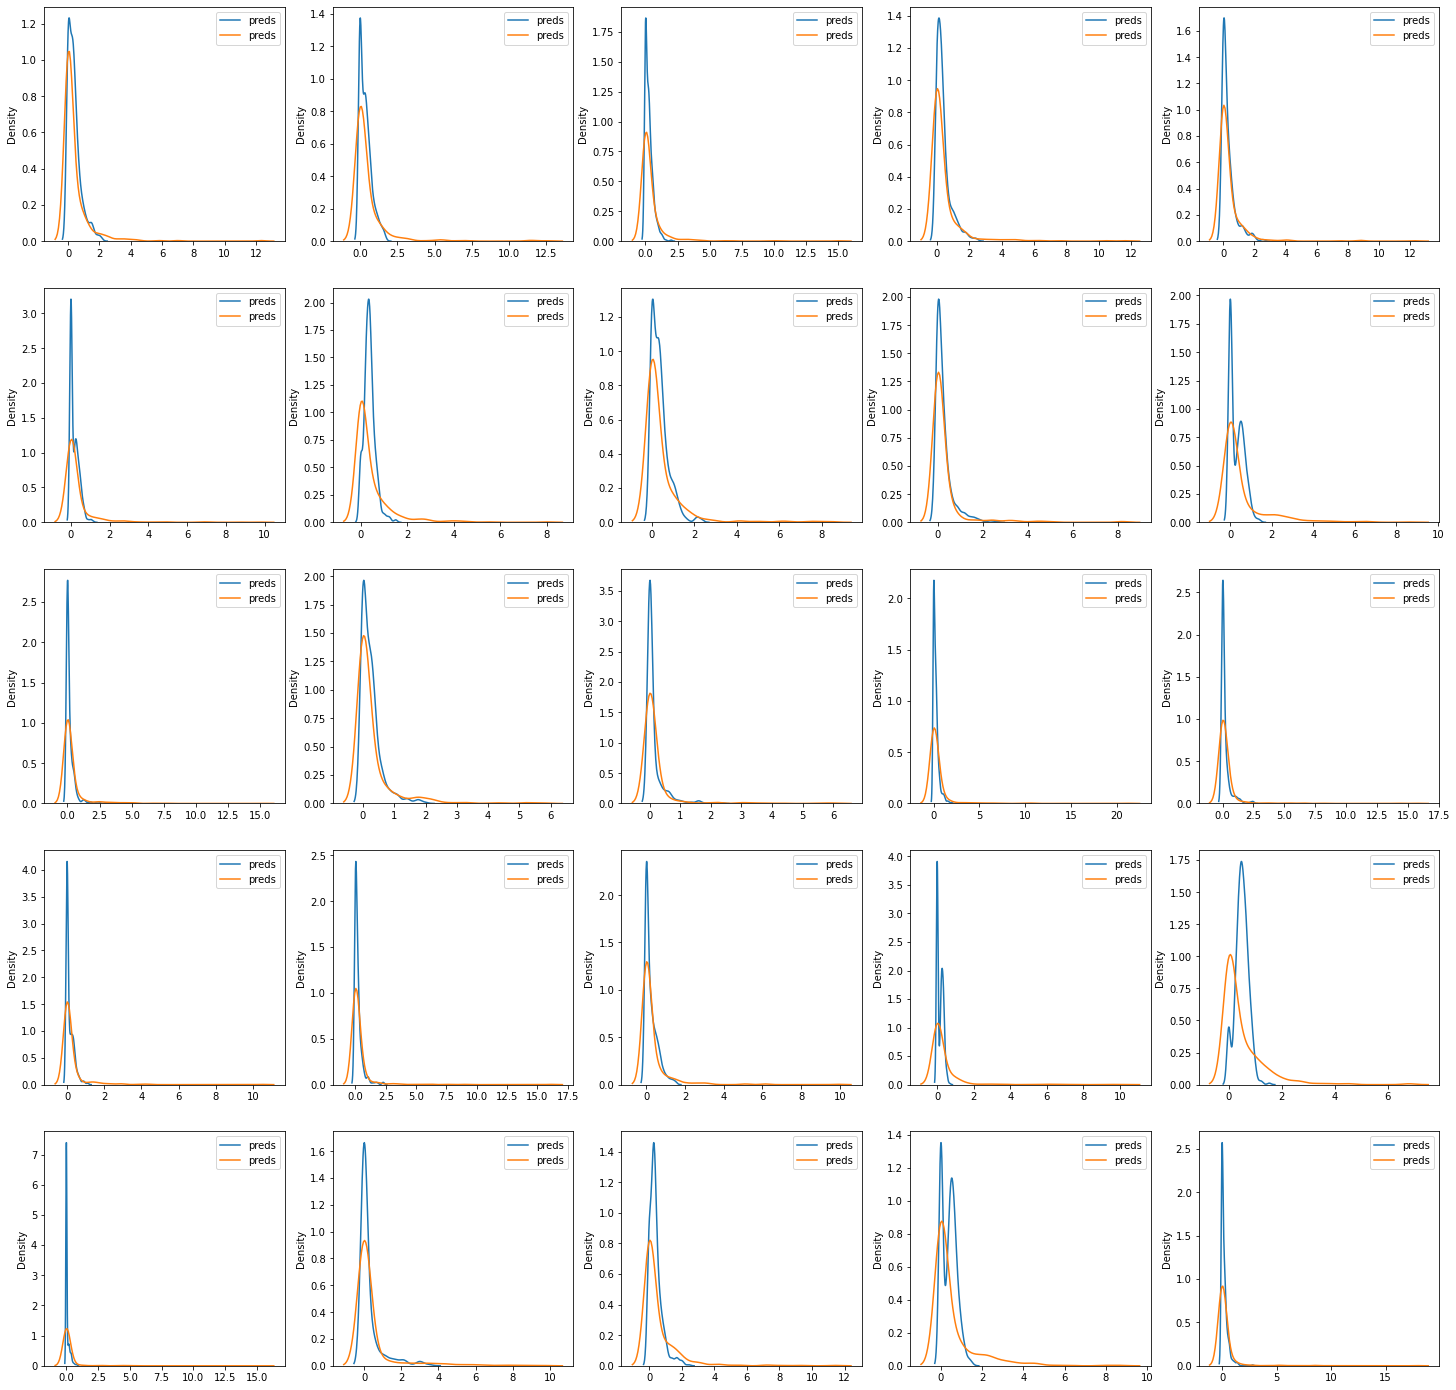

In [27]:
import seaborn as sns
from matplotlib import pyplot as plt
fig, axes = plt.subplots(5, 5, figsize=(25, 25))
for idx, ax in enumerate(axes.flatten()):
    sns.kdeplot(preds[:, idx].detach().numpy(), ax=ax, label='preds')
    sns.kdeplot(labels[:, idx].detach().numpy(), ax=ax, label='labels')
    ax.legend()

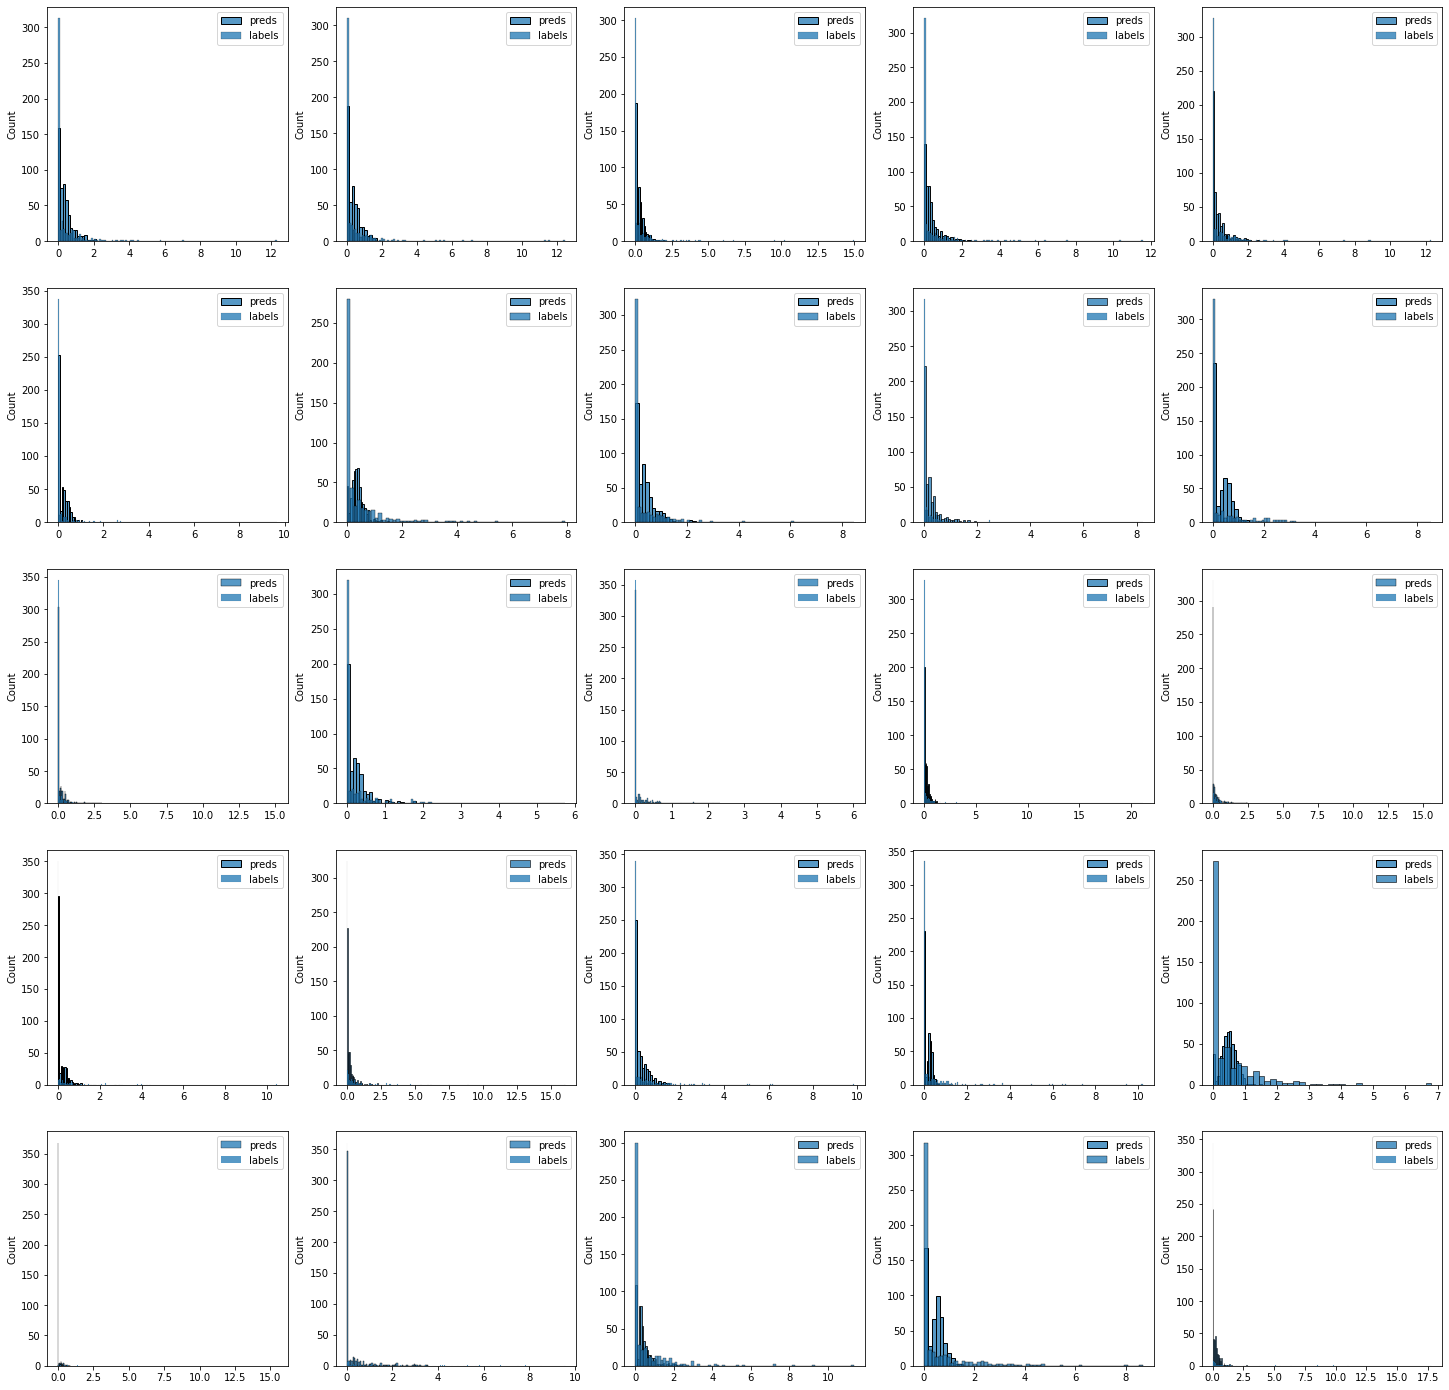

In [28]:
import seaborn as sns
from matplotlib import pyplot as plt
fig, axes = plt.subplots(5, 5, figsize=(25, 25))
for idx, ax in enumerate(axes.flatten()):
    sns.histplot(preds[:, idx].detach().numpy(), ax=ax, label='preds')
    sns.histplot(labels[:, idx].detach().numpy(), ax=ax, label='labels')
    ax.legend()

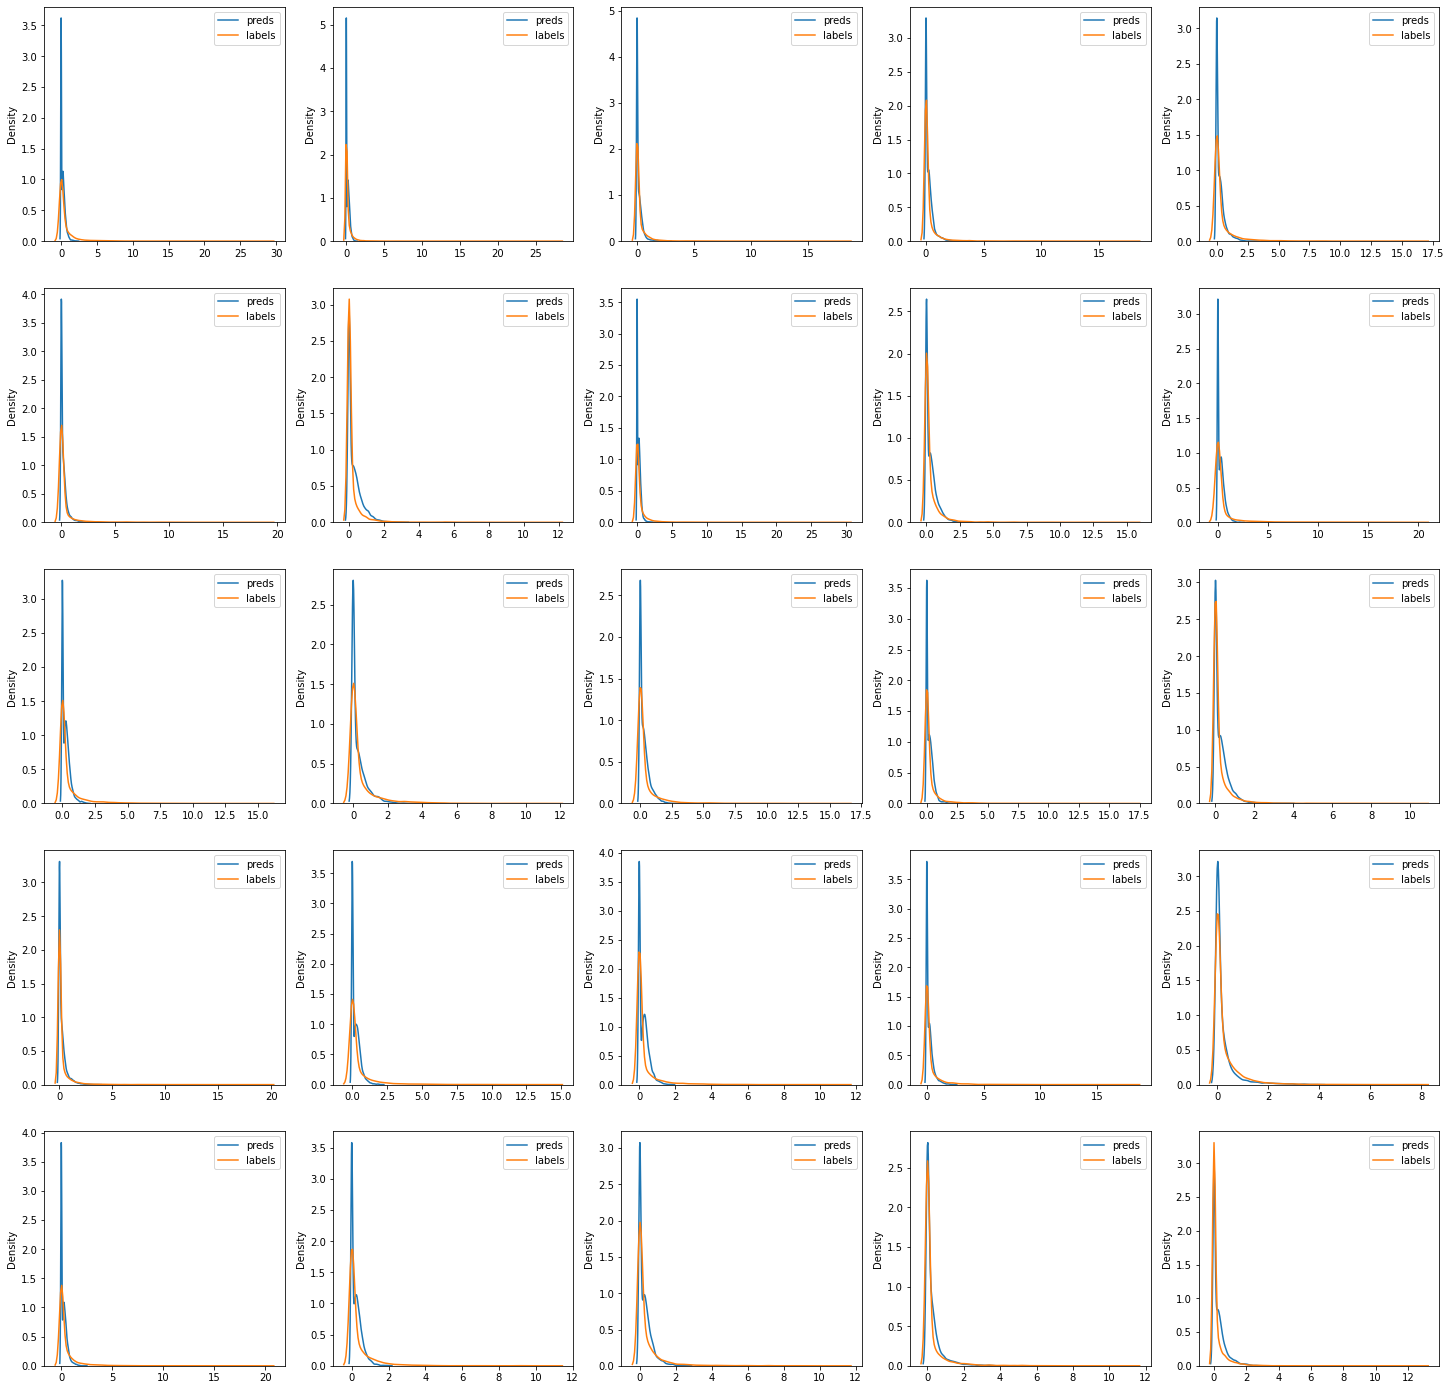

In [29]:
import seaborn as sns
from matplotlib import pyplot as plt
fig, axes = plt.subplots(5, 5, figsize=(25, 25))
for idx, ax in enumerate(axes.flatten()):
    sns.kdeplot(preds[idx, :].detach().numpy(), ax=ax, label='preds')
    sns.kdeplot(labels[idx, :].detach().numpy(), ax=ax, label='labels')
    ax.legend()

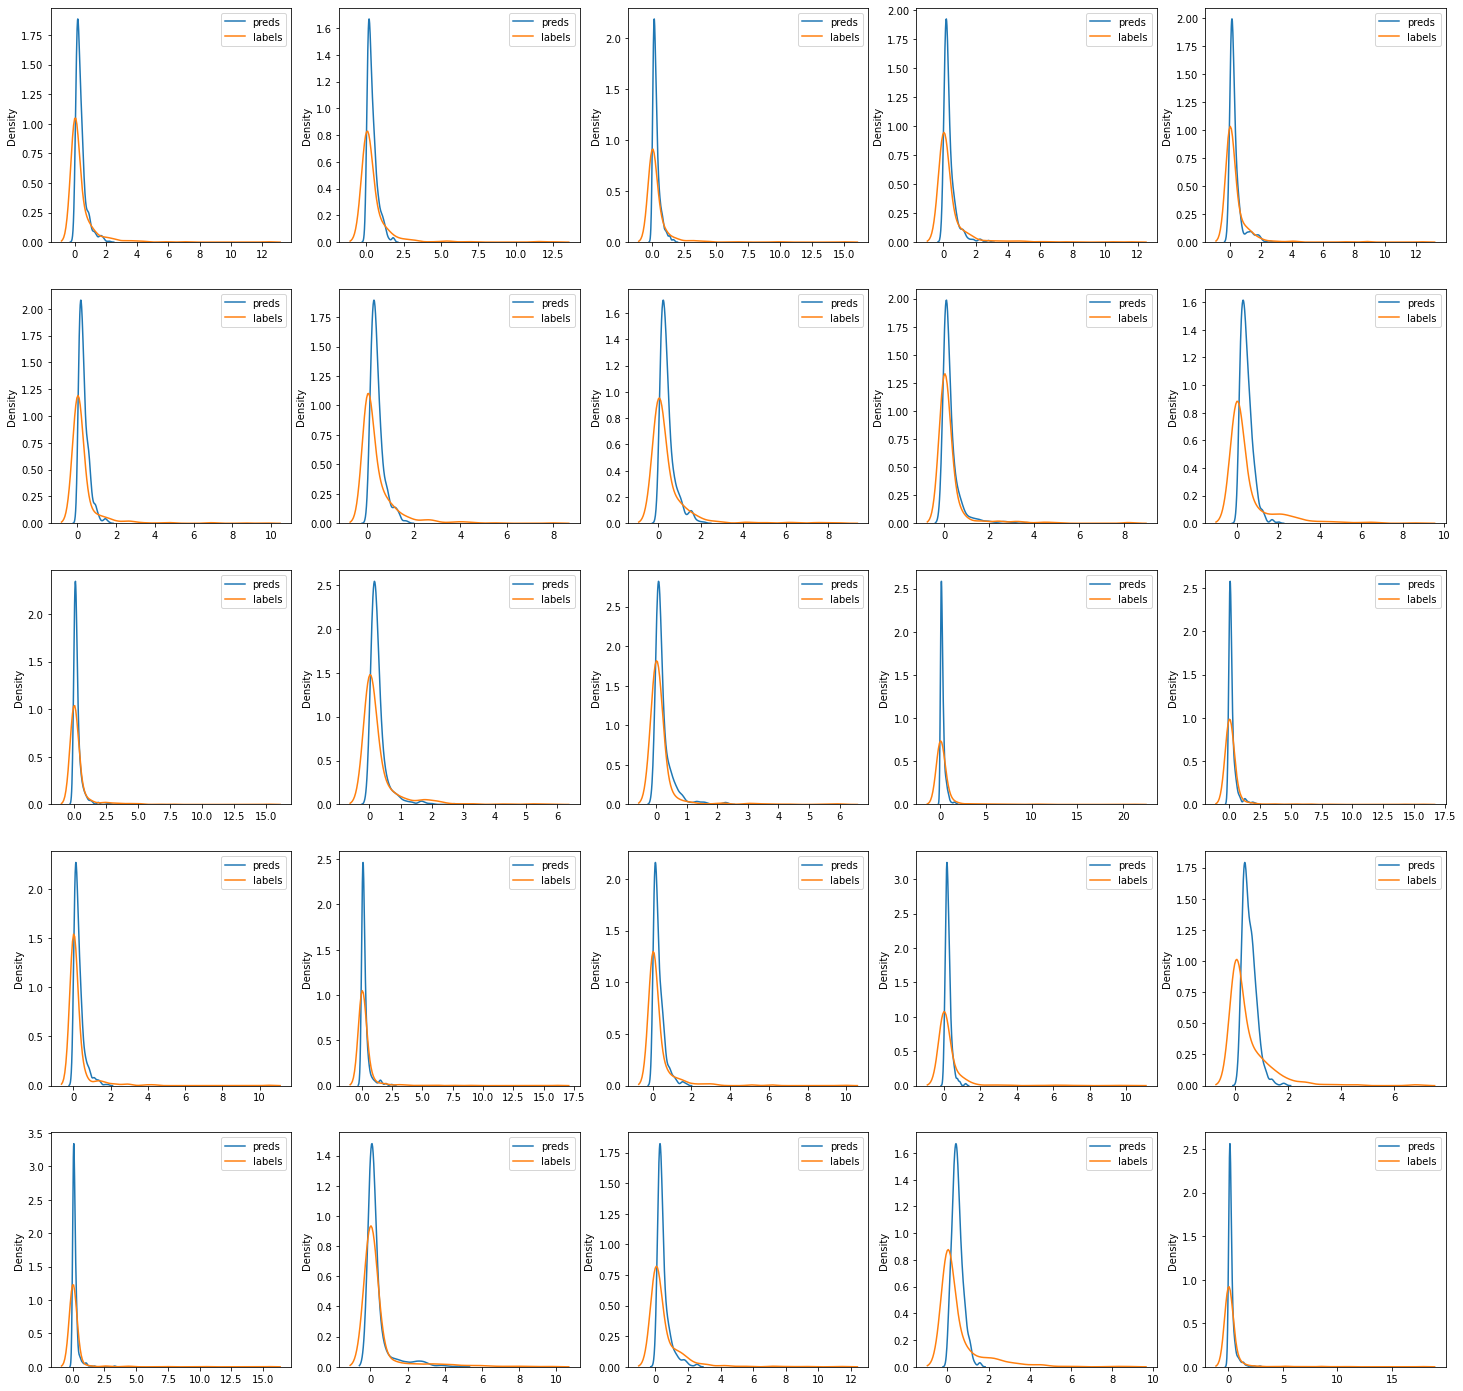

In [32]:
import seaborn as sns
from matplotlib import pyplot as plt
fig, axes = plt.subplots(5, 5, figsize=(25, 25))
for idx, ax in enumerate(axes.flatten()):
    sns.kdeplot(preds[:, idx].detach().numpy(), ax=ax, label='preds')
    sns.kdeplot(labels[:, idx].detach().numpy(), ax=ax, label='labels')
    ax.legend()

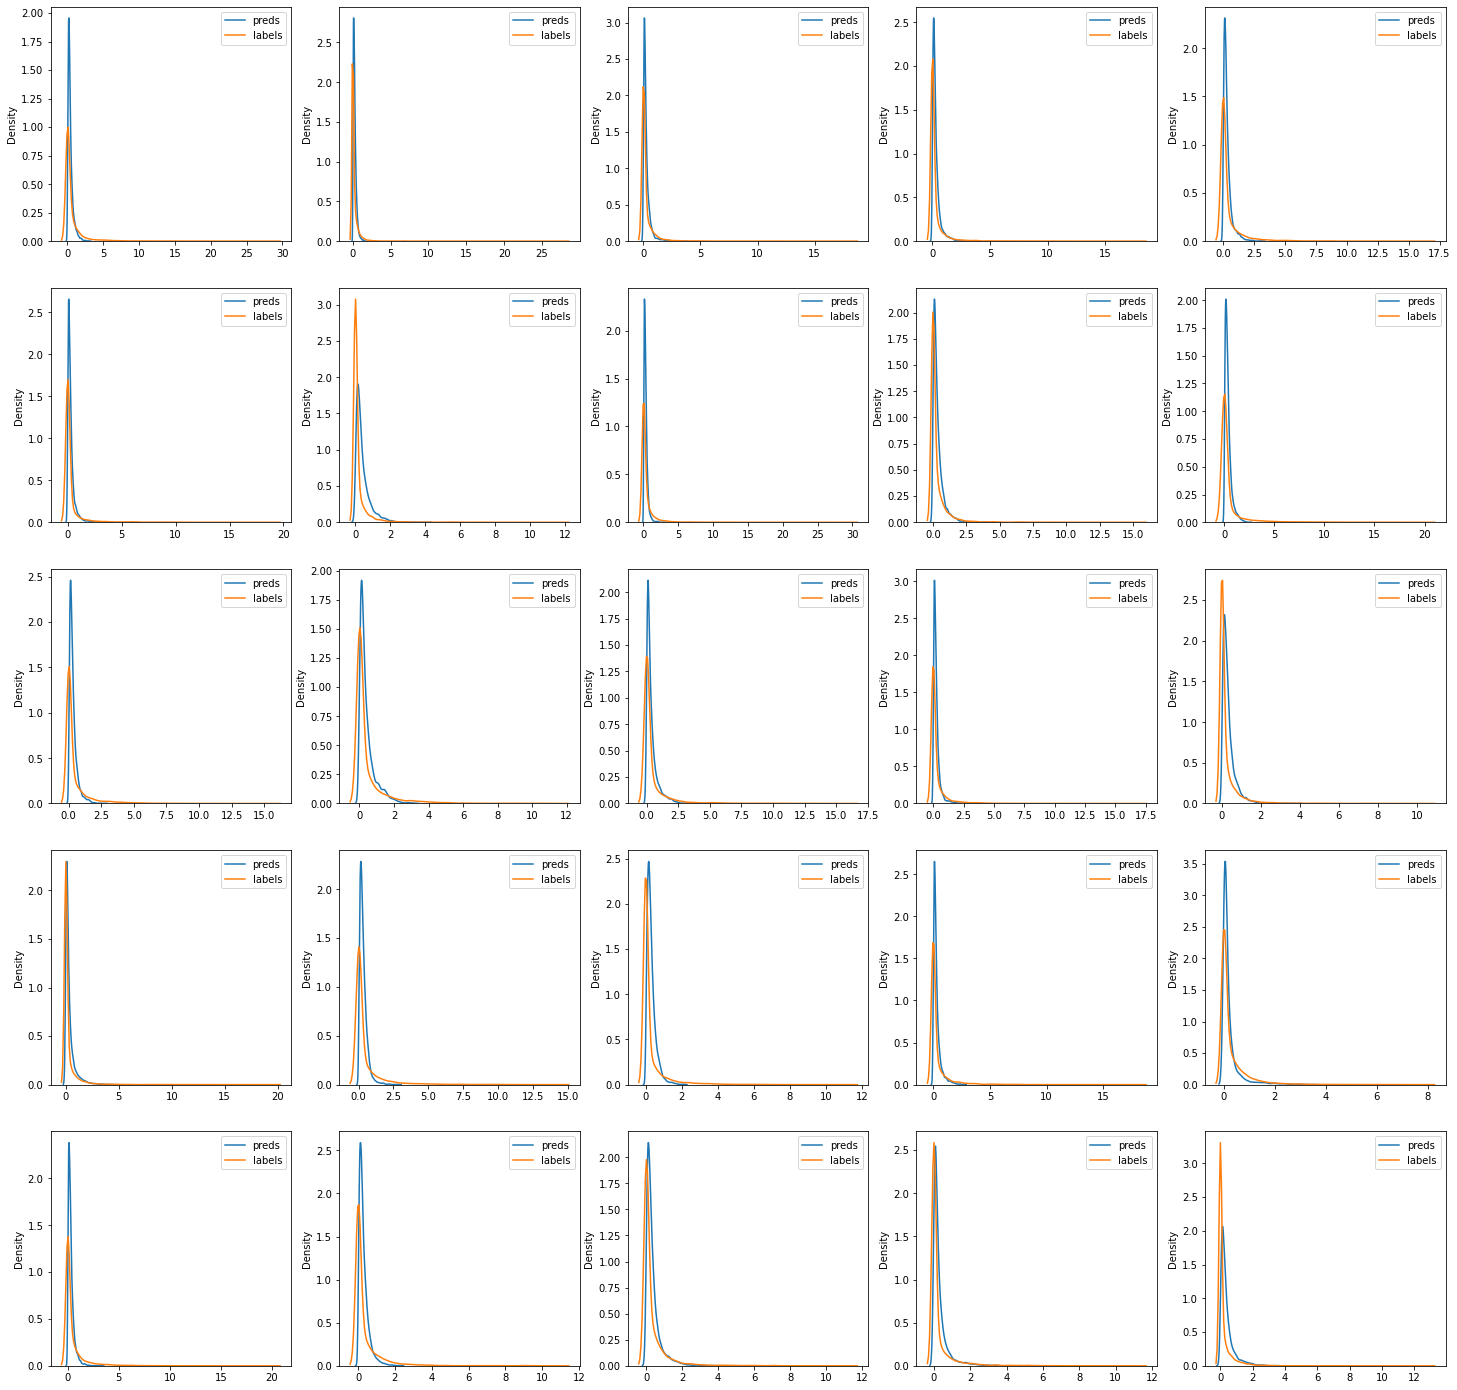

In [33]:
import seaborn as sns
from matplotlib import pyplot as plt
fig, axes = plt.subplots(5, 5, figsize=(25, 25))
for idx, ax in enumerate(axes.flatten()):
    sns.kdeplot(preds[idx, :].detach().numpy(), ax=ax, label='preds')
    sns.kdeplot(labels[idx, :].detach().numpy(), ax=ax, label='labels')
    ax.legend()